<a href="https://colab.research.google.com/github/sbarreto10/data-science-2022/blob/main/SPOTIFY%20DATASET%20(TP3)/75_06_TP_3_BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LECTURA**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
pd.options.mode.chained_assignment = None

In [ ]:
trainDf = pd.read_parquet("/content/drive/MyDrive/tp3/train.parquet")
testDf = pd.read_parquet("/content/drive/MyDrive/tp3/test.parquet")

# **SPLIT**

In [ ]:
random.seed(3)
artistList = trainDf.artist.unique().tolist()
validationArtists = random.sample(artistList, int(0.2*len(artistList)))
trainDf, valDf = trainDf.query("artist not in @validationArtists"), trainDf.query("artist in @validationArtists")

# **PREPROCESAMIENTO**

In [ ]:
import string
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stopwordsSpEn = set(stopwords.words('english')+stopwords.words('spanish'))
sPunctuations = list(string.punctuation)
sDigits = list(string.digits)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
genreList = trainDf["genre"].unique()

In [ ]:
def str_type_count(x, tset):
    words = x.split()
    return len([s for s in words if s in tset])

def digit_count(x):
    return len([d for d in x if d in sDigits])

def word_max(x):
    words = word_tokenize(x)
    return 0 if len(words)==0 else max([len(w) for w in words])

def word_min(x):
    words = word_tokenize(x)
    return 0 if len(words)==0 else min([len(w) for w in words if w not in stopwordsSpEn])

def word_mean(x):
    words = word_tokenize(x)
    return 0 if len(words)==0 else np.mean([len(w) for w in words])

def sent_max(x):
    sents = sent_tokenize(x)
    return 0 if len(sents)==0 else max([len(s) for s in sents])

def sent_min(x):
    sents = sent_tokenize(x)
    return 0 if len(sents)==0 else min([len(s) for s in sents])

def sent_mean(x):
    sents = sent_tokenize(x)
    return 0 if len(sents)==0 else np.mean([len(s) for s in sents])

def preprocess(df):
    # ARREGLOS Y DROPEOS
    try:
        df["genre"][df[df.genre == "Children's Music"].index[0]] = "Children’s Music"
    except:
        pass
    df = df.drop(columns = ["track_name","did","artist","a_genres","a_songs"])

    # IMPUTACIÓN DE NULOS
    s_labelMean = df["s-label"].mean()
    df.lyric = df.lyric.fillna("").astype(str)
    df.language = df.language.map(lambda x: "ot" if type(x)==type(None) else x)
    df["s-label"] = df["s-label"].fillna(s_labelMean)
    df["mode"] = df["mode"].map(lambda m: int(m=="Major"))

    # CREACIÓN DE FEATURES A PARTIR DE LAS LYRICS
    df["lyricCharCount"] = df.lyric.map(len)
    df["lyricWordCount"] = df.lyric.map(lambda x: len(word_tokenize(x)))
    df["lyricUniqueWordCount"] = df.lyric.map(lambda x: len(set(x.split())))
    df["lyricSentenceCount"] = df.lyric.map(lambda x: len(sent_tokenize(x)))
    df["lyricUniqueSentenceCount"] = df.lyric.map(lambda x: len(set(sent_tokenize(x))))
    df["lyricDigitCount"] = df.lyric.map(digit_count)
    df["lyricStopwordCount"] = df.lyric.map(lambda x: str_type_count(x, stopwordsSpEn))
    df["lyricPunctuationCount"] = df.lyric.map(lambda x: str_type_count(x, sPunctuations))
    df["lyricLongestWordLen"] = df.lyric.map(word_max)
    df["lyricShortestWordLen"] = df.lyric.map(word_min)
    df["lyricWordLenMean"] = df.lyric.map(word_mean)
    df["lyricLongestSentenceLen"] = df.lyric.map(sent_max)
    df["lyricShortestSentenceLen"] = df.lyric.map(sent_min)
    df["lyricSentenceLenMean"] = df.lyric.map(sent_mean)

    return df

In [ ]:
trainDf = preprocess(trainDf)
valDf = preprocess(valDf)
testDf = preprocess(testDf)

# **ESTANDARIZACIÓN Y ENCODING**

In [ ]:
def normalized(column):
    colStd = column.std()
    return (column - column.mean()) / colStd if colStd!=0 else 0 * column

In [ ]:
def normalize_df(df, featureList):
    for f in featureList:
        df[f] = normalized(df[f])
    return df

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df, catCols):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[catCols])
    encFts = list(encoder.get_feature_names(catCols))
    df[encFts] = encoder.transform(df[catCols])
    return df

In [ ]:
catCols = ["language","time_signature","key"]
trainDf = one_hot_encode(trainDf, catCols)
valDf = one_hot_encode(valDf, catCols)
testDf = one_hot_encode(testDf, catCols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
featureList = [f for f in trainDf if f not in ["genre","lyric","language","time_signature","key"]]

In [ ]:
# HAY CATEGORÍAS EN EL TRAIN_DF QUE NO ESTÁN EN EL VAL_DF O EN EL TEST_DF
# COMO EL ONEHOTENCODING NO LAS CREO, LAS CREO COMO NULAS
for f in featureList:
    if f not in valDf:
        valDf[f] = 0
    if f not in testDf:
        testDf[f] = 0

In [ ]:
trainDf = normalize_df(trainDf, featureList)
valDf = normalize_df(valDf, featureList)
testDf = normalize_df(testDf, featureList)

In [ ]:
testDf = testDf.query("genre in @genreList")
valDf = valDf.query("genre in @genreList")

In [ ]:
X_train, y_train = trainDf[featureList], trainDf.genre.astype(str)
X_test, y_test = testDf[featureList], testDf.genre.astype(str)
X_val, y_val = valDf[featureList], valDf.genre.astype(str)

# **ENTRENAMIENTO Y OPTIMIZACIÓN**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import top_k_accuracy_score
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
mlModel = LogisticRegression(multi_class = 'multinomial', random_state = 33)
mlModel.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial', random_state=33)

In [ ]:
hpar_space = {
    "penalty": ['none', 'l1', 'l2', 'elasticnet'],
    "C": np.logspace(0, 4, 20),
    "solver": ['newton-cg', 'lbfgs', 'liblinear']
}

In [ ]:
search = RandomizedSearchCV(mlModel, hpar_space, n_iter=12, cv=3, scoring='accuracy', verbose=10, random_state=420)
result = search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START C=18.329807108324356, penalty=l2, solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3; 1/12] END C=18.329807108324356, penalty=l2, solver=lbfgs;, score=0.339 total time=   5.1s
[CV 2/3; 1/12] START C=18.329807108324356, penalty=l2, solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3; 1/12] END C=18.329807108324356, penalty=l2, solver=lbfgs;, score=0.306 total time=   5.0s
[CV 3/3; 1/12] START C=18.329807108324356, penalty=l2, solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3; 1/12] END C=18.329807108324356, penalty=l2, solver=lbfgs;, score=0.210 total time=   5.0s
[CV 1/3; 2/12] START C=4.281332398719393, penalty=l2, solver=newton-cg..........
[CV 1/3; 2/12] END C=4.281332398719393, penalty=l2, solver=newton-cg;, score=0.342 total time= 1.4min
[CV 2/3; 2/12] START C=4.281332398719393, penalty=l2, solver=newton-cg..........
[CV 2/3; 2/12] END C=4.281332398719393, penalty=l2, solver=newton-cg;, score=0.307 total time=  52.4s
[CV 3/3; 2/12] START C=4.281332398719393, penalty=l2, solver=newton-cg..........
[CV 3/3; 2/12] END C=4.281332398719393, penalty=l2, solver=newton-cg;, score=0.235 total time=  59.4s
[CV 1/3; 3/12] START C=10000.0, penalty=elasticnet, solver=liblinear............
[CV 1/3; 3/12] END C=10000.0, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 3/12] START C=10000.0, penalty=elasticnet, solver=liblinear............
[CV 2/3; 3/12] END C=10000.0, penalty=elasticnet, solver=liblinear;, score=nan total time=  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


[CV 1/3; 4/12] END C=6158.48211066026, penalty=l2, solver=newton-cg;, score=0.341 total time= 3.8min
[CV 2/3; 4/12] START C=6158.48211066026, penalty=l2, solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


[CV 2/3; 4/12] END C=6158.48211066026, penalty=l2, solver=newton-cg;, score=0.306 total time= 3.6min
[CV 3/3; 4/12] START C=6158.48211066026, penalty=l2, solver=newton-cg...........


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 3/3; 4/12] END C=6158.48211066026, penalty=l2, solver=newton-cg;, score=0.173 total time= 3.5min
[CV 1/3; 5/12] START C=335.9818286283781, penalty=l1, solver=liblinear..........
[CV 1/3; 5/12] END C=335.9818286283781, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 5/12] START C=335.9818286283781, penalty=l1, solver=liblinear..........
[CV 2/3; 5/12] END C=335.9818286283781, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 3/3; 5/12] START C=335.9818286283781, penalty=l1, solver=liblinear..........
[CV 3/3; 5/12] END C=335.9818286283781, penalty=l1, solver=liblinear;, score=nan total time=   0.0s
[CV 1/3; 6/12] START C=2.636650898730358, penalty=none, solver=newton-cg........


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 1/3; 6/12] END C=2.636650898730358, penalty=none, solver=newton-cg;, score=0.341 total time= 3.7min
[CV 2/3; 6/12] START C=2.636650898730358, penalty=none, solver=newton-cg........


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[CV 2/3; 6/12] END C=2.636650898730358, penalty=none, solver=newton-cg;, score=0.305 total time= 3.5min
[CV 3/3; 6/12] START C=2.636650898730358, penalty=none, solver=newton-cg........


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


[CV 3/3; 6/12] END C=2.636650898730358, penalty=none, solver=newton-cg;, score=0.171 total time= 3.3min
[CV 1/3; 7/12] START C=78.47599703514611, penalty=l1, solver=lbfgs..............
[CV 1/3; 7/12] END C=78.47599703514611, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 7/12] START C=78.47599703514611, penalty=l1, solver=lbfgs..............
[CV 2/3; 7/12] END C=78.47599703514611, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/3; 7/12] START C=78.47599703514611, penalty=l1, solver=lbfgs..............
[CV 3/3; 7/12] END C=78.47599703514611, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/3; 8/12] START C=545.5594781168514, penalty=elasticnet, solver=liblinear..
[CV 1/3; 8/12] END C=545.5594781168514, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/3; 8/12] START C=545.5594781168514, penalty=elasticnet, solver=liblinear..
[CV 2/3; 8/12] END C=545.5594781168514, penalty=elasticnet, solver=liblinear;, score=nan total 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3; 9/12] END C=1.6237767391887217, penalty=l2, solver=lbfgs;, score=0.340 total time=   4.9s
[CV 2/3; 9/12] START C=1.6237767391887217, penalty=l2, solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3; 9/12] END C=1.6237767391887217, penalty=l2, solver=lbfgs;, score=0.307 total time=   4.7s
[CV 3/3; 9/12] START C=1.6237767391887217, penalty=l2, solver=lbfgs.............


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3; 9/12] END C=1.6237767391887217, penalty=l2, solver=lbfgs;, score=0.215 total time=   4.8s
[CV 1/3; 10/12] START C=1.6237767391887217, penalty=l2, solver=newton-cg........
[CV 1/3; 10/12] END C=1.6237767391887217, penalty=l2, solver=newton-cg;, score=0.342 total time=  41.3s
[CV 2/3; 10/12] START C=1.6237767391887217, penalty=l2, solver=newton-cg........
[CV 2/3; 10/12] END C=1.6237767391887217, penalty=l2, solver=newton-cg;, score=0.306 total time=  29.1s
[CV 3/3; 10/12] START C=1.6237767391887217, penalty=l2, solver=newton-cg........
[CV 3/3; 10/12] END C=1.6237767391887217, penalty=l2, solver=newton-cg;, score=0.235 total time=  33.3s
[CV 1/3; 11/12] START C=885.8667904100823, penalty=l1, solver=lbfgs.............
[CV 1/3; 11/12] END C=885.8667904100823, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/3; 11/12] START C=885.8667904100823, penalty=l1, solver=lbfgs.............
[CV 2/3; 11/12] END C=885.8667904100823, penalty=l1, solver=lbfgs;, score=nan total tim

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 459, in _check_solver
    solver
ValueError: Only 'saga' solver s

In [ ]:
mlModel = result.best_estimator_

In [ ]:
mlModel

LogisticRegression(C=4.281332398719393, multi_class='multinomial',
                   random_state=33, solver='newton-cg')

# **VALIDACIÓN**

In [ ]:
valProbs = mlModel.predict_proba(X_val)
bestValScore = top_k_accuracy_score(y_val, valProbs, k=2, labels=mlModel.classes_)

# **PREGUNTAS**

In [ ]:
#@title ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)
print("Mejor score de validación: " + str(bestValScore))
print("\nEl dataset de entrenamiento original es dividido en un 80% para entrenamiento y un 20% para validación tal que cada subset")
print("tenga un conjunto diferente de artistas. Esto debido a que es muy probable que un artista se corresponda con un solo género,")
print("filtrando el label a predecir y, por ende, causando overfitting")

Mejor score de validación: 0.5173401209035953

El dataset de entrenamiento original es dividido en un 80% para entrenamiento y un 20% para validación tal que cada subset
tenga un conjunto diferente de artistas. Esto debido a que es muy probable que un artista se corresponda con un solo género,
filtrando el label a predecir y, por ende, causando overfitting


In [ ]:
#@title Al predecir con este modelo para test, ¿Cúal es el score obtenido?
testProbs = mlModel.predict_proba(X_test)
testScore = top_k_accuracy_score(y_test, testProbs, k=2, labels=mlModel.classes_)
print("Score obtenido en el dataset de test: " + str(testScore))

Score obtenido en el dataset de test: 0.474949221394719


In [ ]:
pd.DataFrame(testProbs, columns=mlModel.classes_, index=X_test.index).to_csv("/content/drive/MyDrive/tp3/parte2/PrediccionesTestBaseline.csv")

Features que son remarcablemente importantes:
a_popularity (Popularidad del artista)
lyricWordCount (Cantidad de palabras de la lyric)





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


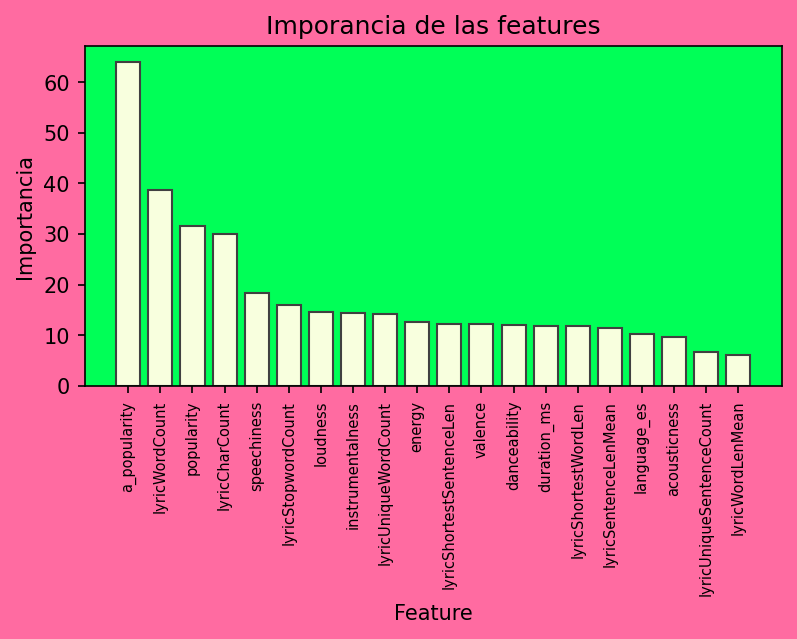

In [ ]:
#@title ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.
explDict = {"a_popularity": "Popularidad del artista",
            "lyricWordCount": "Cantidad de palabras de la lyric",
            "lyricCharCount": "Cantidad de caractreres de la lyric"}
ftImportances = pd.DataFrame(mlModel.coef_, index=mlModel.classes_, columns=mlModel.feature_names_in_)\
                .transform(abs).sum()\
                .sort_values(ascending=False).head(20)
halfOfMaxFt = ftImportances.max()/2
print("Features que son remarcablemente importantes:")
for f in ftImportances.index:
    if ftImportances[f]>halfOfMaxFt:
        print(f + " (" + explDict[f] + ")")
print("\n\n")

plt.figure(dpi=150, figsize=(6,3), facecolor="#FF6BA1")

X_axis = np.arange(len(ftImportances))

plt.bar(X_axis, ftImportances, 0.75, color="#F8FFDE", edgecolor="#404040")

plt.axes().set_facecolor("#00FF57")
plt.xlabel("Feature")
plt.ylabel("Importancia")
plt.title("Imporancia de las features")
plt.xticks(X_axis, ftImportances.index, rotation=90, size=7)
plt.show()